<div  >
<img src="https://raw.githubusercontent.com/threeML/astromodels/master/docs/media/transp_logo.png" alt="drawing" width="300" align="right"/>
 


<div  >
<img src="https://raw.githubusercontent.com/threeML/threeML/master/logo/logo_sq.png" alt="drawing" width="300" align="right"/>



# X-ray Analysis with 3ML
    
While 3ML can handle a lot of different data/likelihood types a lot of attention was spent on making sure that users familiar with past community standards are able to easily adapt to the 3ML workflow. There are some guides for these users in the [documentation](https://threeml.readthedocs.io/en/stable/xspec_users.html).
    
X-ray analysis in 3ML is centered around the `OGIPLike` plugin which reads OGIP style PHAI/II, RMF, and ARF files. the OGIPLike plugin is a specialized version of the `DispersionSpectrumLike` plugin which deals with count data that are produced by convolving the model spectrum with the resonse of an instrument that suffers from energy dispersion. Thus, if you have an instrument you are designing and you don't like fits files... inherit from DispersionSpectrumLike and create your own unique plugin for ROOT, HDF5, txt, etc. files. The cool thing is that you can still fit your data along with normal OGIP type data... or any of the other plugins in the 3ML family. 3ML is a toolbox to bring instruments (and people) together. 
    
    
Let's explore the OGIPLike plugin

 


## The OGIPLike plugin

The OGIP plugin reads in standard OGIP files. **It will complain a lot if files are in the correct format!**. For PHAII files with multiple spectra, you can use the familiar `<filename>{<spectrum_number>}` format to specify file names or you can pass a spectrum number as an argument. 

<img src="https://cdn.pixabay.com/photo/2012/11/28/11/16/star-67705_960_720.jpg" alt="drawing" width="400" align="center"/>


In the tutorial, there are some simulated Chandra data. Let's say that these data come from the observation of a a white drawf atmosphere. Let's see what we can do with these data.


In [1]:
from threeML import *
# get xspec models
#from astromodels.xspec import *
update_logging_level("INFO")
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

%matplotlib notebook
from jupyterthemes import jtplot
jtplot.style(context='notebook', fscale=1, ticks=True, grid=False)


In [33]:
chandra = OGIPLike(name="chandra", 
                   observation="c_data/obs.pha", 
                   background="c_data/obs_bak.pha",
                   response="c_data/acis.rmf",
                   arf_file="c_data/acis.arf",
                   spectrum_number=1 )

[WARNING ] Maximum MC energy (12.0) is smaller than maximum EBOUNDS energy (14.950400352478027)
[WARNING ] Minimum MC energy (0.2549999952316284) is larger than minimum EBOUNDS energy (0.007300000172108412)
[DEBUG   ] c_data/obs.pha has rates and NOT counts
[DEBUG   ] c_data/obs.pha is not a time series
[DEBUG   ] c_data/obs.pha is Poisson
[DEBUG   ] c_data/obs_bak.pha has rates and NOT counts
[DEBUG   ] c_data/obs_bak.pha is not a time series
[DEBUG   ] c_data/obs_bak.pha is Poisson
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: poisson
[DEBUG   ] Starting precalculations
[DEBUG   ] background set in precalculations
[DEBUG   ] this is a normal background observation
[DEBUG   ] completed precalculations


Note that 3ML probed the type of data that were read in. As long as the data files have been appropriately labelled, the plugin will **choose the correct likelihood for you**. While freedom is a great thing, math is not a democracy and thus we follow the rules so that your fits are of the highest scientific rigour. 

In this case, the total observation and the background observation are Poisson distributed. Thus, the proper likelihood is a Poisson for the total observation conditional ont he Poisson likelihood of the background. For now, we will not model the background. Therefore a profile likelihood will be choosen.

Let's examine the properties of the plugin.


In [34]:
chandra.significance

23.710500294188734

In [35]:
chandra.significance_per_channel

array([ 2.60437566,  0.3336778 ,  1.16584403, ...,  0.58292201,
               nan, -0.        ])

<IPython.core.display.Javascript object>


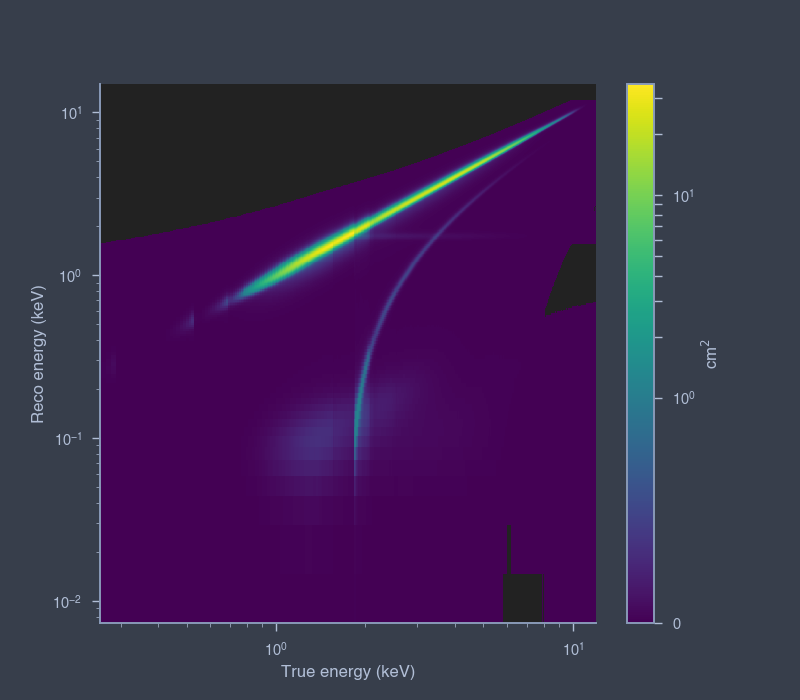


WARNING MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()



In [5]:
chandra.display_rsp()

In [6]:
chandra.exposure

1.0

<IPython.core.display.Javascript object>


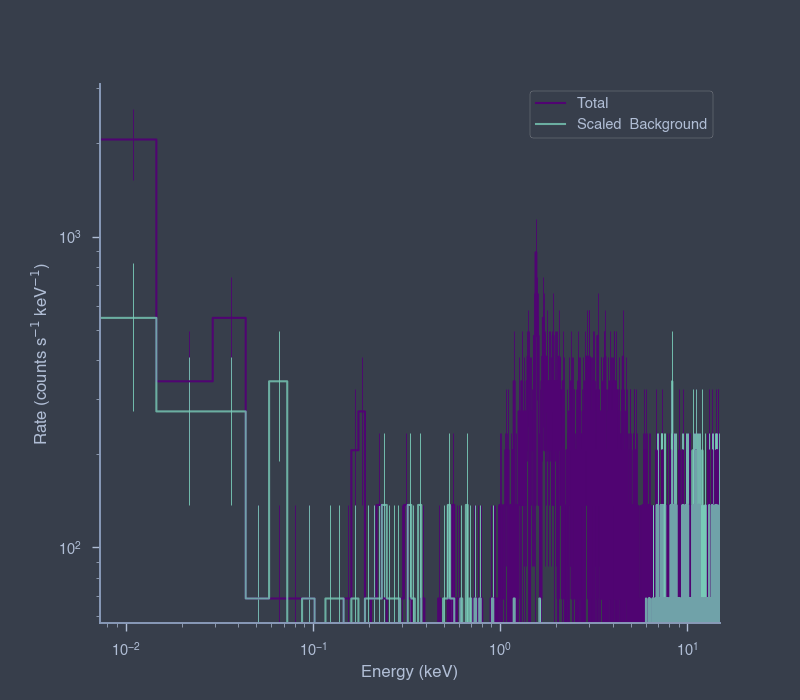

In [36]:
chandra.view_count_spectrum();

Now, not all channels are great to use in an analysis. Thus, we can set our selections.

In [8]:
chandra.set_active_measurements?

In [9]:
chandra.set_active_measurements('0.2-10')

[INFO    ] Range 0.2-10 translates to channels 13-684


<IPython.core.display.Javascript object>


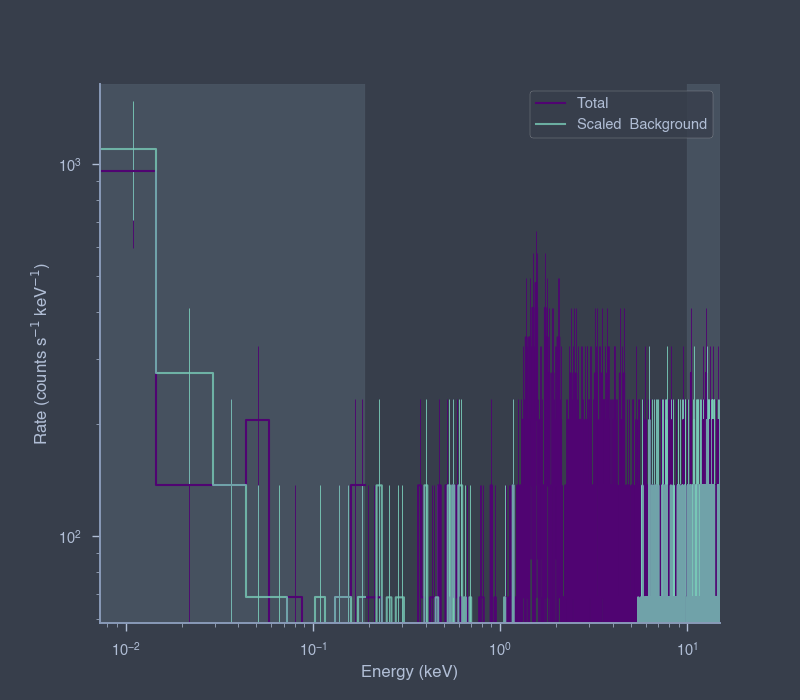


WARNING UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



In [10]:
chandra.view_count_spectrum();

For profile likelihoods to valid, there must be at least 1 [background count per channel](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/). Let's do that here:

In [11]:
chandra.rebin_on_background(1)
#chandra.remove_rebinning()

[INFO    ] Now using 121 bins


<IPython.core.display.Javascript object>


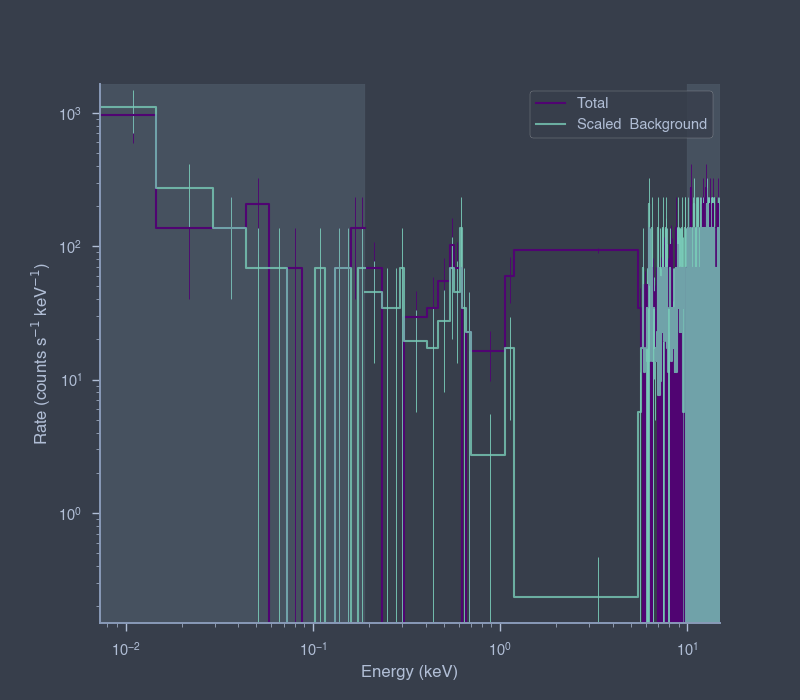


WARNING UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



In [12]:
chandra.view_count_spectrum();

## Fitting 

Ok, we are basically ready to do a fit. But we need a model. Let's make two models, one of a black body and the other a power law. We are going to be Bayesians for now, but remember, there is little difference between the interface for the two approaches.

### blackbody model


In [45]:
bb = Blackbody()

#priors
bb.K.prior = Log_uniform_prior(lower_bound = 1e-2, upper_bound = 10)
bb.kT.prior = Truncated_gaussian(mu= 1, sigma=2, lower_bound=0, upper_bound=10)

# source
ps_bb = PointSource("white_drawf_bb", 0, 0, spectral_shape=bb)

# model
model_bb = Model(ps_bb)

In [22]:
bayes_bb = BayesianAnalysis(model_bb, DataList(chandra))

# let's use ultranest this time
bayes_bb.set_sampler("ultranest")

bayes_bb.sampler.setup(min_num_live_points=400)

_ = bayes_bb.sample()

[INFO    ] sampler set to ultranest
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+02  .55 [-299.5575..-299.5574]*| it/evals=5040/10307 eff=50.8630% N=399  0  
[ultranest] Likelihood function evaluations: 10307
[ultranest]   logZ = -307.6 +- 0.09015
[ultranest] Effective samples strategy satisfied (ESS = 1665.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.09 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
white_drawf_bb.spectrum.main.Blackbody.K,(7.5 +/- 2.6) x 10^-1,1 / (cm2 keV3 s)
white_drawf_bb.spectrum.main.Blackbody.kT,1.03 +/- 0.12,keV



Values of -log(posterior) at the minimum:



,-log(posterior)
chandra,-300.551079
total,-300.551079



Values of statistical measures:



,statistical measures
AIC,605.120096
BIC,614.122676
DIC,600.379881
PDIC,-2.839834
log(Z),-133.579167


<IPython.core.display.Javascript object>


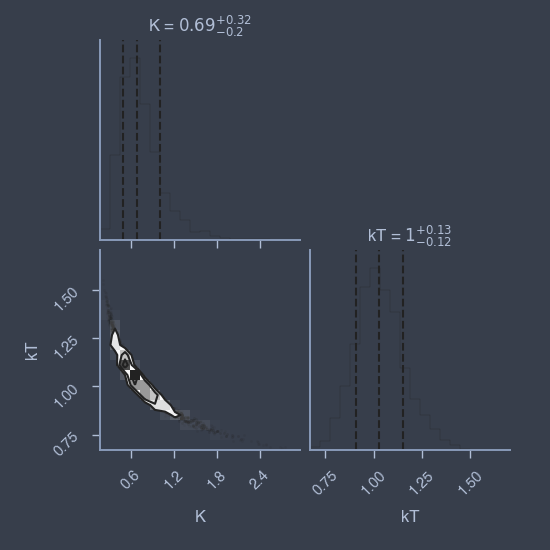

In [23]:
bayes_bb.results.corner_plot();

<IPython.core.display.Javascript object>


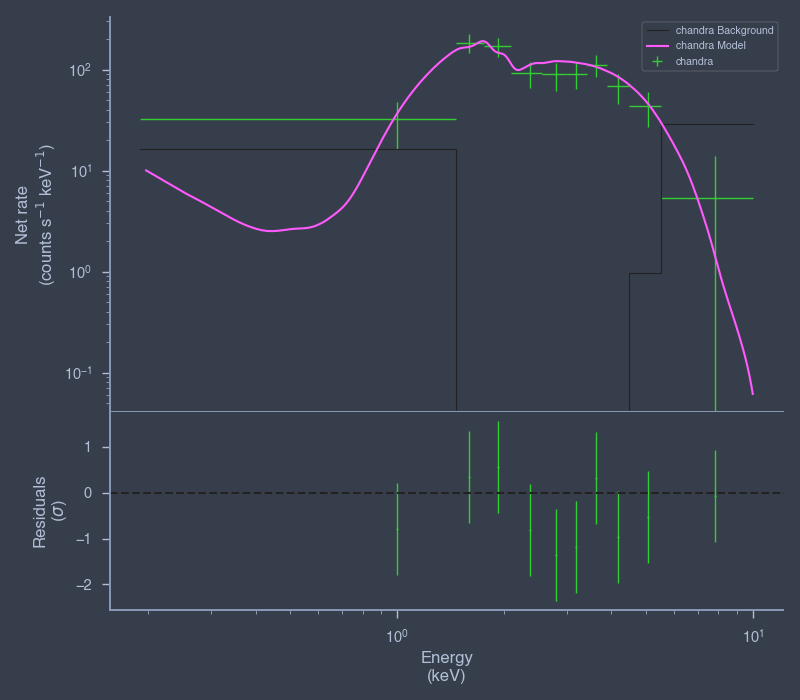


WARNING MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



In [24]:
display_spectrum_model_counts(bayes_bb,
                              min_rate=50,
                              show_background=True);



In [25]:
show_configuration('plugins')

plugins
 ╠═ ogip
 ║  ╠═ fit_plot
 ║  ║  ╠═ data_cmap
 ║  ║  ║  ╚═ MPLCmap.Set1
 ║  ║  ╠═ model_cmap
 ║  ║  ║  ╚═ MPLCmap.Spectral
 ║  ║  ╠═ background_cmap
 ║  ║  ║  ╚═ MPLCmap.Set1
 ║  ║  ╠═ n_colors
 ║  ║  ║  ╚═ 5
 ║  ║  ╠═ step
 ║  ║  ║  ╚═ False
 ║  ║  ╠═ show_legend
 ║  ║  ║  ╚═ True
 ║  ║  ╠═ show_residuals
 ║  ║  ║  ╚═ True
 ║  ║  ╠═ data_color
 ║  ║  ║  ╚═ limegreen
 ║  ║  ╠═ model_color
 ║  ║  ║  ╚═ #FF5AFD
 ║  ║  ╠═ background_color
 ║  ║  ║  ╚═ k
 ║  ║  ╠═ show_background
 ║  ║  ║  ╚═ False
 ║  ║  ╠═ data_mpl_kwargs
 ║  ║  ║  ╚═ None
 ║  ║  ╠═ model_mpl_kwargs
 ║  ║  ║  ╚═ None
 ║  ║  ╚═ background_mpl_kwargs
 ║  ║     ╠═ lw
 ║  ║     ║  ╚═ 0.8
 ║  ║     ╚═ ls
 ║  ║        ╚═ -
 ║  ╠═ data_plot
 ║  ║  ╠═ counts_color
 ║  ║  ║  ╚═ #500472
 ║  ║  ╠═ background_color
 ║  ║  ║  ╚═ #79cbb8
 ║  ║  ╠═ warn_channels_color
 ║  ║  ║  ╚═ #C79BFE
 ║  ║  ╠═ bad_channels_color
 ║  ║  ║  ╚═ #FE3131
 ║  ║  ╚═ masked_channels_color
 ║  ║     ╚═ #566573
 ║  ╠═ response_cmap
 ║  ║  ╚═ MPLCmap.

In [26]:
threeML_config.plugins.ogip.fit_plot.data_color = 'limegreen'
threeML_config.plugins.ogip.fit_plot.model_color = '#FF5AFD'

<IPython.core.display.Javascript object>


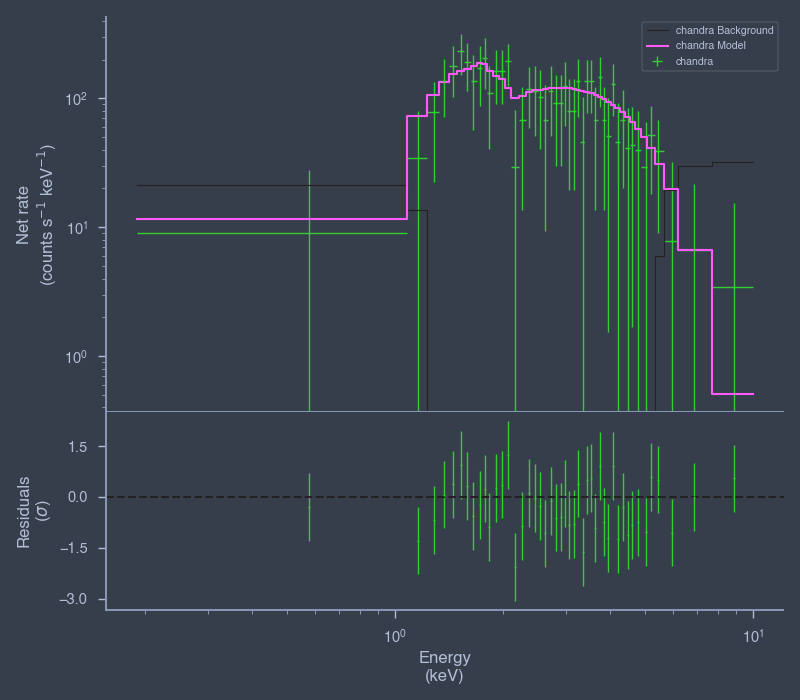


WARNING MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



In [27]:
display_spectrum_model_counts(bayes_bb,
                              min_rate=10,
                              step=True,
                              show_background=True);




### power law model

In [28]:
plaw = Powerlaw()

plaw.K.prior = Log_uniform_prior(lower_bound = 1e-2, upper_bound = 10) 

plaw.index.prior = Gaussian(mu=-1, sigma=2)
plaw.index.bounds = (None, None)


# source
ps_pl = PointSource("white_drawf_pl", 0, 0, spectral_shape=plaw)

# model
model_pl = Model(ps_pl)

In [29]:
bayes_pl = BayesianAnalysis(model_pl, DataList(chandra))

# let's use ultranest this time
bayes_pl.set_sampler("ultranest")

bayes_pl.sampler.setup(min_num_live_points=400)

_ = bayes_pl.sample()

[INFO    ] sampler set to ultranest
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+02  .95 [-307.9608..-307.9608]*| it/evals=4440/6192 eff=76.6575% N=400 00  
[ultranest] Likelihood function evaluations: 6212
[ultranest]   logZ = -314.5 +- 0.07776
[ultranest] Effective samples strategy satisfied (ESS = 1605.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.12 bs:0.08 tail:0.01 total:0.08 required:<0.50
[ultranest] done iterating.
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
white_drawf_pl.spectrum.main.Powerlaw.K,(8.0 +/- 1.4) x 10^-1,1 / (cm2 keV s)
white_drawf_pl.spectrum.main.Powerlaw.index,(-9.7 +/- 1.7) x 10^-1,



Values of -log(posterior) at the minimum:



,-log(posterior)
chandra,-308.546318
total,-308.546318



Values of statistical measures:



,statistical measures
AIC,621.110573
BIC,630.113152
DIC,621.039111
PDIC,1.947265
log(Z),-136.581041


<IPython.core.display.Javascript object>


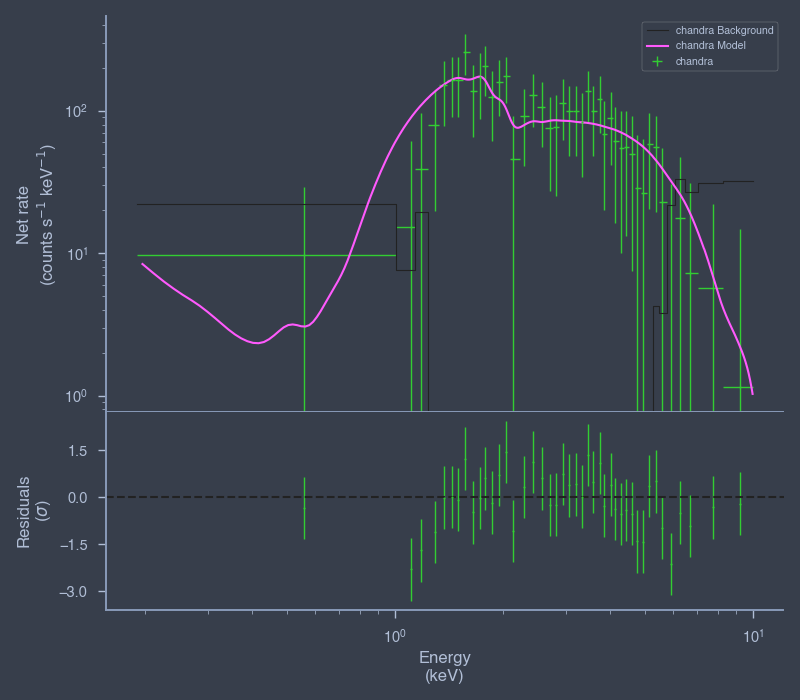


WARNING MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



In [30]:
display_spectrum_model_counts(bayes_pl,
                              min_rate=10,
                              show_background=True);

processing Bayesian analyses:   0%|          | 0/2 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


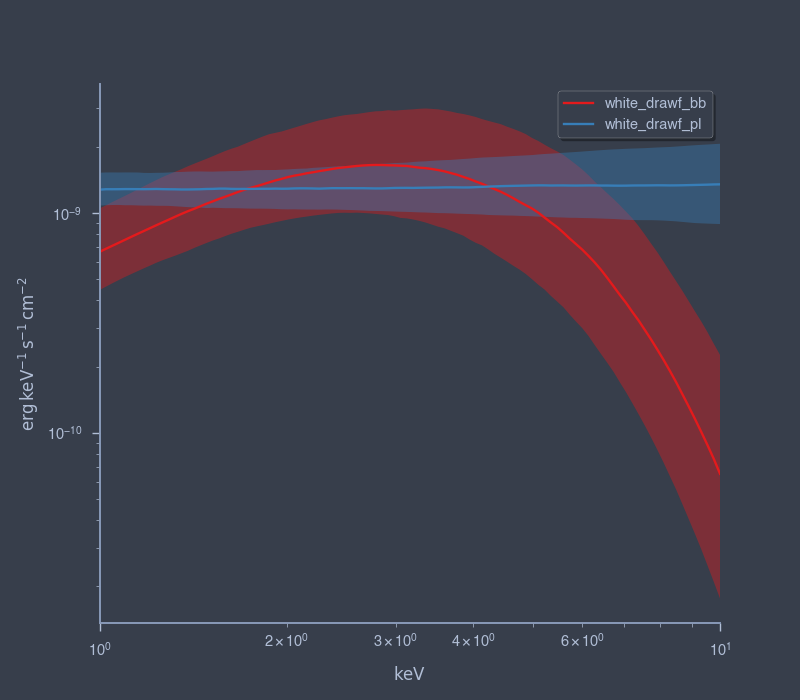

In [31]:
plot_spectra(bayes_bb.results, bayes_pl.results,
             flux_unit="erg/(cm2 s keV)",
             ene_min=1*u.keV, ene_max=10*u.keV);

## posterior predictive checks (PPC)

Let's use an external package to 3ML (but built with its tools box!) to compute posterior predictive checks. PPCs are model checking tool that integrate over the posterior and likelihood to compute the probability of new data from the observed data. We can compute this via simulating new data from the likelihood for sampled points from our posterior. A more detailed explanation for this can be found [here](https://academic.oup.com/mnras/article/490/1/927/5570608).

In [30]:
from twopc import compute_ppc

In [31]:
ppc_bb = compute_ppc(bayes_bb,
                  bayes_bb.results,
                  n_sims=500,
                  file_name="ppc_bb.h5",
                  return_ppc=True, overwrite=True)

sampling posterior:   0%|          | 0/500 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


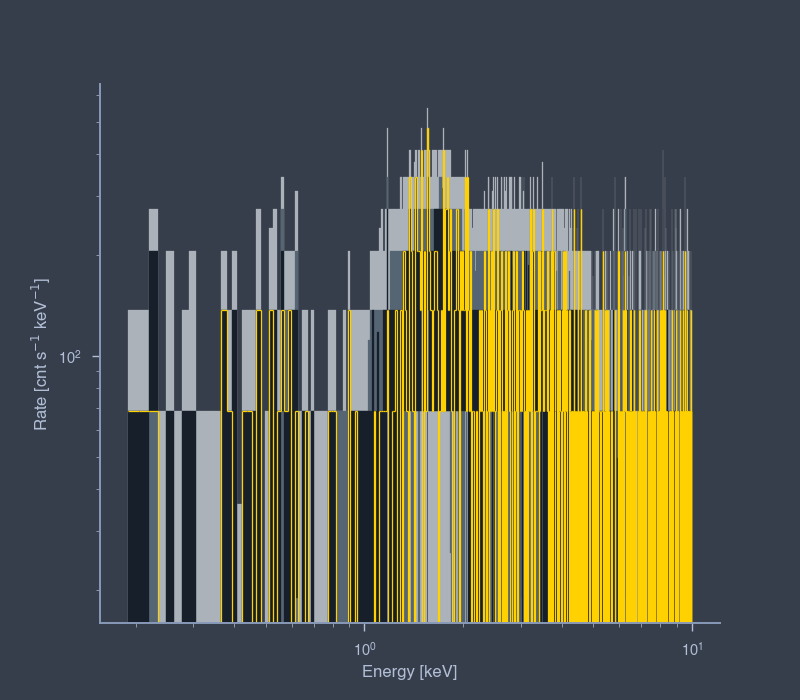

In [32]:
ppc_bb.chandra.plot();

<IPython.core.display.Javascript object>


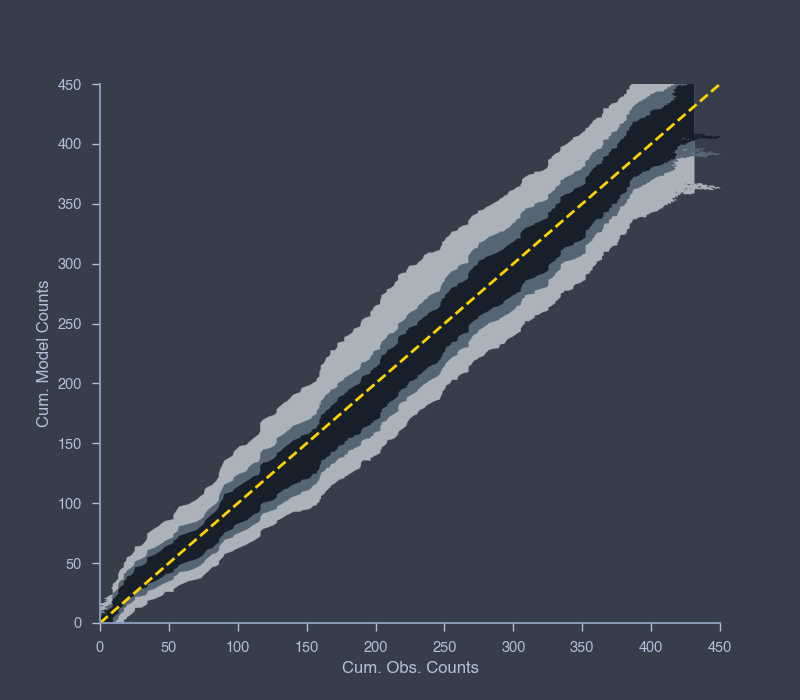

In [33]:
ppc_bb.chandra.plot_qq(channel_energies=None);

In [34]:
ppc_pl = compute_ppc(bayes_pl,
                  bayes_pl.results,
                  n_sims=500,
                  file_name="ppc_pl.h5",
                  return_ppc=True, overwrite=True)

sampling posterior:   0%|          | 0/500 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


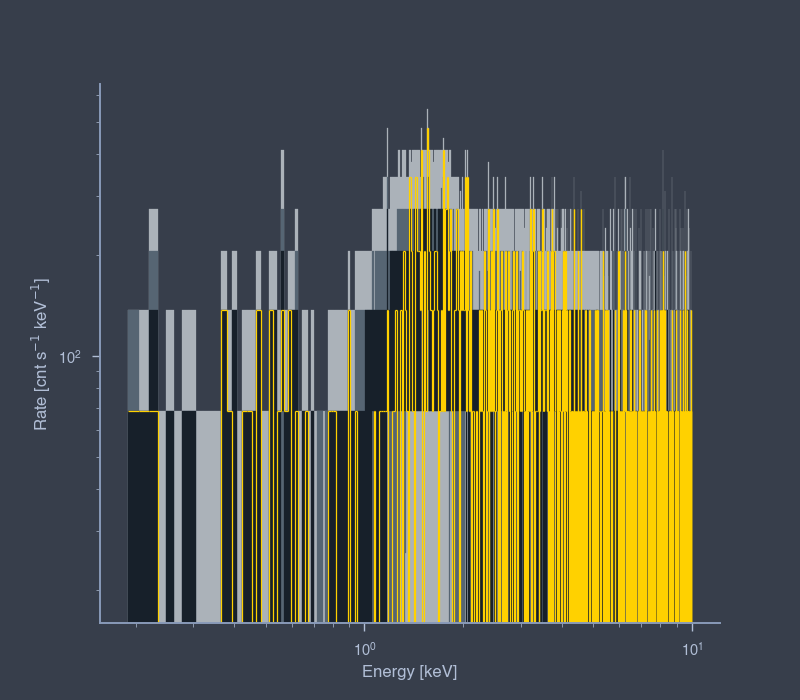

In [35]:
ppc_pl.chandra.plot();

<IPython.core.display.Javascript object>


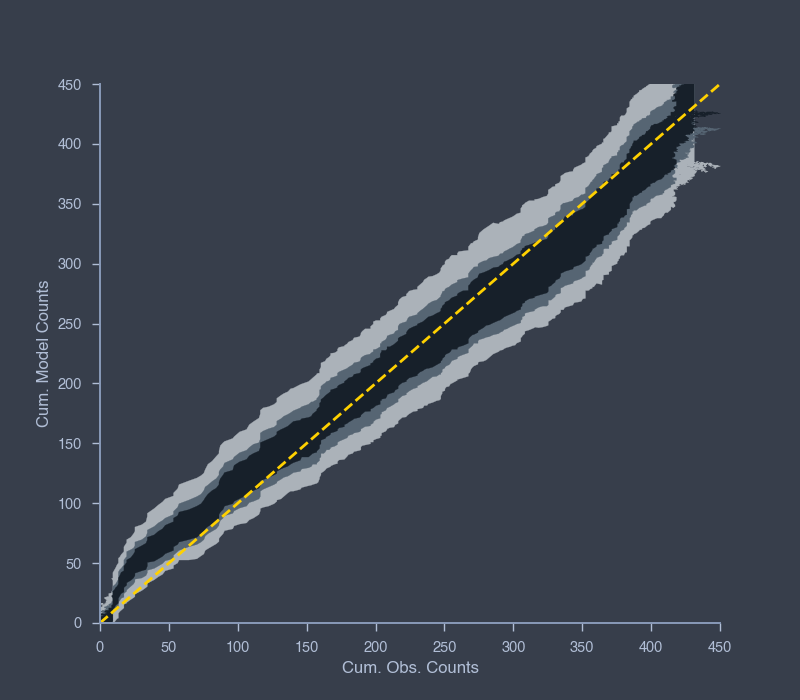

In [36]:
ppc_pl.chandra.plot_qq(channel_energies=None);

In [46]:
bkg_plugin = SpectrumLike.from_background("bkg", chandra)

[DEBUG   ] creating new spectrumlike from background
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: None
[DEBUG   ] Starting precalculations
[DEBUG   ] no background set in precalculations
[DEBUG   ] completed precalculations


In [47]:
bkg_spectrum = Powerlaw(K=1.5,index=-1.5) + Gaussian(F=.2, mu=0.75, sigma=.1) + Gaussian(F=.3, mu=5, sigma=.1)

bkg_spectrum.K_1.prior = Log_uniform_prior(lower_bound=1e-2, upper_bound=5)
bkg_spectrum.index_1.prior = Truncated_gaussian(mu = -2, sigma=1, lower_bound=-np.inf, upper_bound=0)

bkg_spectrum.F_2.prior = Log_uniform_prior(lower_bound=1e-3, upper_bound=1e0)
bkg_spectrum.mu_2.prior = Truncated_gaussian(mu = 1, sigma=0.5, lower_bound=0, upper_bound=10)
bkg_spectrum.sigma_2.fix = True

bkg_spectrum.F_3.prior = Log_uniform_prior(lower_bound=1e-3, upper_bound=1e0)
bkg_spectrum.mu_3.prior = Truncated_gaussian(mu = 4, sigma=0.5, lower_bound=0, upper_bound=10)
bkg_spectrum.sigma_3.fix = True

bkg_src = PointSource("bkg", 0,0, spectral_shape=bkg_spectrum)

bkg_model = Model(bkg_src)


bkg_plugin.set_model(bkg_model)



[DEBUG   ] bkg is using all point sources


In [20]:
debug_mode()

In [48]:
chandra_bkg = OGIPLike("chandra",
                       observation = "c_data/obs.pha",
                       response = "c_data/acis.rmf", 
                       arf_file = "c_data/acis.arf" ,
                       background = bkg_plugin,
                       spectrum_number=1
                        
                      
                      )

[WARNING ] Maximum MC energy (12.0) is smaller than maximum EBOUNDS energy (14.950400352478027)
[WARNING ] Minimum MC energy (0.2549999952316284) is larger than minimum EBOUNDS energy (0.007300000172108412)
[DEBUG   ] c_data/obs.pha has rates and NOT counts
[DEBUG   ] c_data/obs.pha is not a time series
[DEBUG   ] c_data/obs.pha is Poisson
[DEBUG   ] using a background plugin
[INFO    ] Background modeled from plugin: bkg
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: poisson
[DEBUG   ] chandra is using a modeled background
[DEBUG   ] chandra is using all point sources
[DEBUG   ] chandra is using all point sources
[DEBUG   ] bkg.spectrum.main.composite.K_1 has passed its prior
[DEBUG   ] chandra is using all point sources
[DEBUG   ] chandra is using all point sources
[DEBUG   ] bkg.spectrum.main.composite.index_1 has passed its prior
[DEBUG   ] chandra is using all point sources
[DEBUG   ] bkg.spectrum.main.composite.F_2 has passed its p

<IPython.core.display.Javascript object>


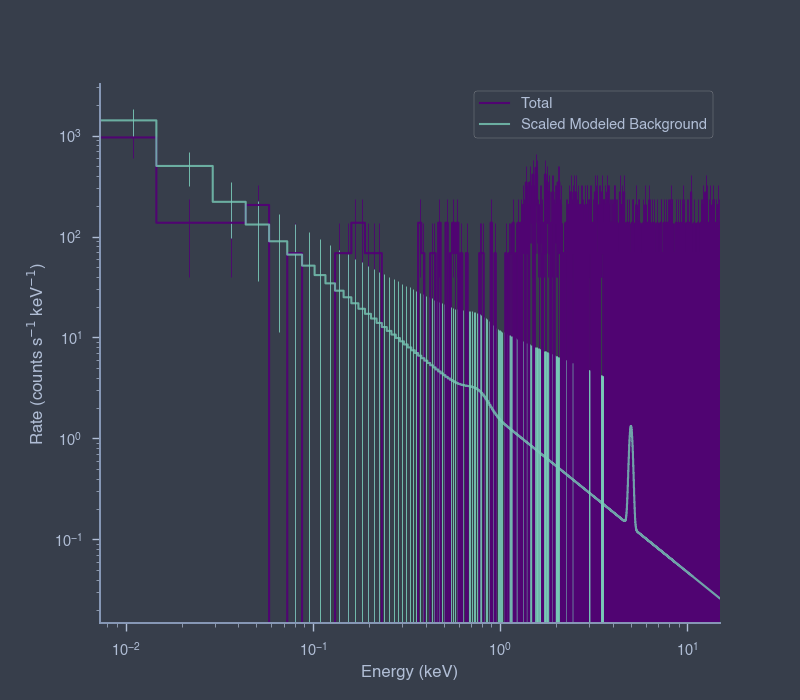

In [22]:
chandra_bkg.view_count_spectrum();

In [23]:
chandra_bkg.nuisance_parameters

OrderedDict([('cons_chandra',
              Parameter cons_chandra = 1.0 []
              (min_value = 0.8, max_value = 1.2, delta = 0.05, free = False)),
             ('bkg_bkg_position_ra_chandra',
              Parameter ra = 0.0 [deg]
              (min_value = 0.0, max_value = 360.0, delta = 0.1, free = False)),
             ('bkg_bkg_position_dec_chandra',
              Parameter dec = 0.0 [deg]
              (min_value = -90.0, max_value = 90.0, delta = 0.1, free = False)),
             ('bkg_bkg_spectrum_main_composite_K_1_chandra',
              Parameter K_1 = 1.5 [1 / (cm2 keV s)]
              (min_value = 1e-30, max_value = 1000.0, delta = 0.1, free = True) [prior: Log_uniform_prior]),
             ('bkg_bkg_spectrum_main_composite_piv_1_chandra',
              Parameter piv_1 = 1.0 [keV]
              (min_value = None, max_value = None, delta = 0.1, free = False)),
             ('bkg_bkg_spectrum_main_composite_index_1_chandra',
              Parameter index_1 = -1.5 []


In [24]:
from ultranest import stepsampler

ss = stepsampler.RegionSliceSampler(nsteps=100)

In [25]:
ss.region_changed

<bound method StepSampler.region_changed of <ultranest.stepsampler.RegionSliceSampler object at 0x13db1f1c0>>

In [49]:
big_model_bb = clone_model(model_bb)

bayes_bkg = BayesianAnalysis(big_model_bb, DataList(chandra_bkg))

# let's use ultranest this time
bayes_bkg.set_sampler("multinest")

bayes_bkg.sampler.setup(n_live_points=1000,verbose=True
    #min_num_live_points=500,
                        #stepsampler=ss
                       
                       )

[DEBUG   ] REGISTER MODEL
[DEBUG   ] model set for chandra
[DEBUG   ] chandra is using all point sources
[DEBUG   ] chandra passing intfral flux function to RSP
[DEBUG   ] MODEL REGISTERED!
[INFO    ] sampler set to multinest
[DEBUG   ] Setup for MultiNest sampler: n_live_points:1000, chain_name:chains/fit-,resume: False, importance_nested_sampling: False.Other input: {'verbose': True}


In [50]:
_ = bayes_bkg.sample()

[DEBUG   ] Start multinest run
[DEBUG   ] Multinest run done
  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
white_drawf_bb.spectrum.main.Blackbody.K,(8.5 -1.0 +0.9) x 10^-1,1 / (cm2 keV3 s)
white_drawf_bb.spectrum.main.Blackbody.kT,1.21 +/- 0.05,keV
K_1,4.985 +/- 0.010,1 / (cm2 keV s)
index_1,(-1.4 +/- 1.0) x 10^-3,
F_2,(9.3 +/- 0.5) x 10^-1,1 / (cm2 s)
mu_2,(5.9 +/- 2.6) x 10^-2,keV
F_3,(3.9 -4 +2.3) x 10^-2,1 / (cm2 s)
mu_3,4.37 +/- 0.32,keV



Values of -log(posterior) at the minimum:



,-log(posterior)
chandra,-2512.787867
total,-2512.787867



Values of statistical measures:



,statistical measures
AIC,5041.717605
BIC,5081.027508
DIC,5037.968479
PDIC,1.644418
log(Z),-1106.975531


<IPython.core.display.Javascript object>


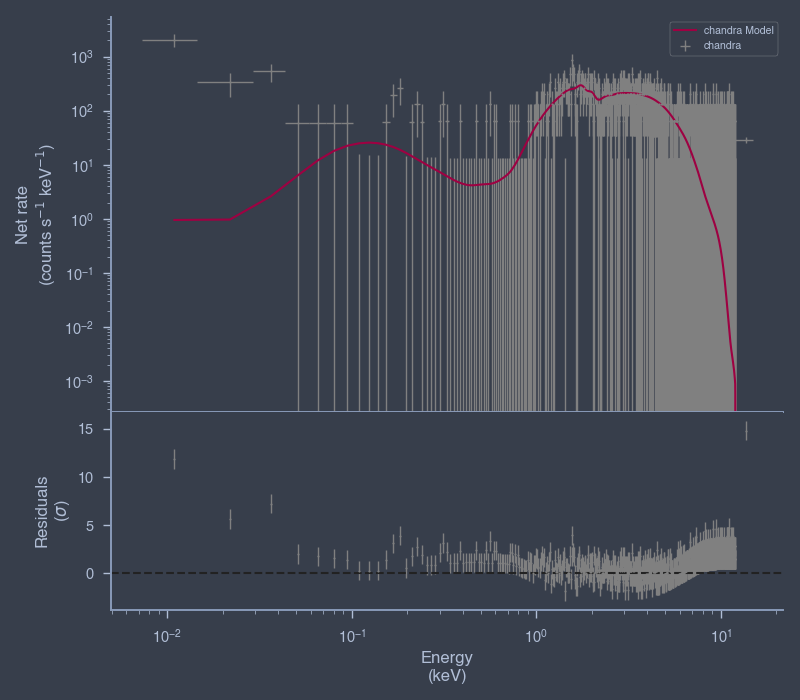

[DEBUG   ] Vector was rebinned from 1024 to 823



WARNING MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



In [51]:
display_spectrum_model_counts(bayes_bkg);

The OGIP plugin (or any plugin) is not just for fitting, it can be used as a generic interface between models and isntruments for building pipelines. 
* Plugins and models are serializable meaning they can be farmed out to multi-processing
* Most plugins can simulate data from their likelihoods (complex instruments still need some work here)

Let's try this out:

<IPython.core.display.Javascript object>


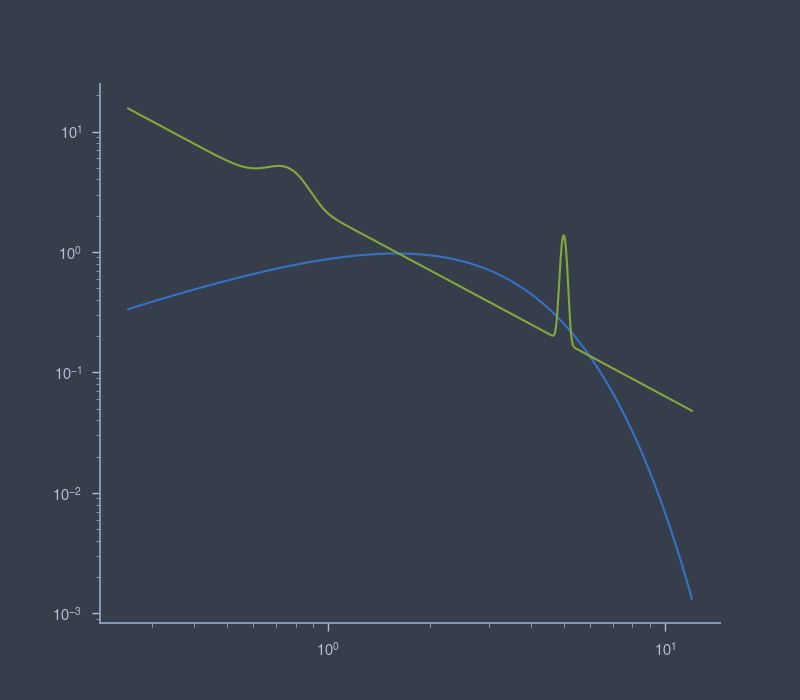

[DEBUG   ] creating new spectrumlike from function
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: None
[DEBUG   ] Starting precalculations
[DEBUG   ] no background set in precalculations
[DEBUG   ] completed precalculations
[DEBUG   ] generator is using all point sources
[DEBUG   ] now have 1
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: None
[DEBUG   ] Starting precalculations
[DEBUG   ] no background set in precalculations
[DEBUG   ] completed precalculations
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: poisson
[DEBUG   ] Starting precalculations
[DEBUG   ] background set in precalculations
[DEBUG   ] this is a normal background observation
[DEBUG   ] completed precalculations
[DEBUG   ] model set for generator
[DEBUG   ] generator is using all point sources
[DEBUG   ] generator passing intfral flux function to RSP
[DEBUG   ] now have 1

In [32]:
bb =  Blackbody(K=1.5,kT = 1.)


bkg = Powerlaw(K=2,index=-1.5) + Gaussian(F=.5, mu=0.75, sigma=.1) + Gaussian(F=.3, mu=5, sigma=.1)

xx= chandra.response.monte_carlo_energies

fig, ax = plt.subplots()

ax.loglog(xx, bb(xx))
ax.loglog(xx, bkg(xx))


geb = DispersionSpectrumLike.from_function('gen',source_function=bb, response=chandra.response, background_function=bkg)
geb.write_pha("c_data/obs", overwrite=True)

In [53]:
import astropy.io.fits as fits

In [65]:
with fits.open("c_data/obs.pha") as f:
    f['SPECTRUM'].header["POISSERR"] = True
    f.flush()
    

In [62]:
f= fits.open("c_data/obs.pha",mode="update")

In [63]:
f['SPECTRUM'].header["POISSERR"] = True

In [64]:
f.flush()

In [61]:
fits.open?